In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import os
import seaborn as sns
from proj1_helpers import *

SEED = 4

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
#its my datapath
DATA_TRAIN_PATH = r'C:/Users/Tomas/GitHub/ML_course/projects/project1/data/train1.csv/train.csv' # TODO: download train data and supply path here 
y, tx, ids = load_csv_data(DATA_TRAIN_PATH)
print(y.shape)
print(tx.shape)
print(ids.shape)

(250000,)
(250000, 30)
(250000,)


## 1) Exploratory Data Analysis
Explore data

In [3]:
y

array([ 1., -1., -1., ...,  1., -1., -1.])

In [4]:
tx

array([[ 138.47 ,   51.655,   97.827, ...,    1.24 ,   -2.475,  113.497],
       [ 160.937,   68.768,  103.235, ..., -999.   , -999.   ,   46.226],
       [-999.   ,  162.172,  125.953, ..., -999.   , -999.   ,   44.251],
       ...,
       [ 105.457,   60.526,   75.839, ..., -999.   , -999.   ,   41.992],
       [  94.951,   19.362,   68.812, ..., -999.   , -999.   ,    0.   ],
       [-999.   ,   72.756,   70.831, ..., -999.   , -999.   ,    0.   ]])

In [5]:
ids

array([100000, 100001, 100002, ..., 349997, 349998, 349999])

In [6]:
print('max = ',np.max(tx))
print('min = ', np.min(tx))

max =  4974.979
min =  -999.0


Display all tx data in a heatmap

Text(0.5, 1.0, 'Feature visualization')

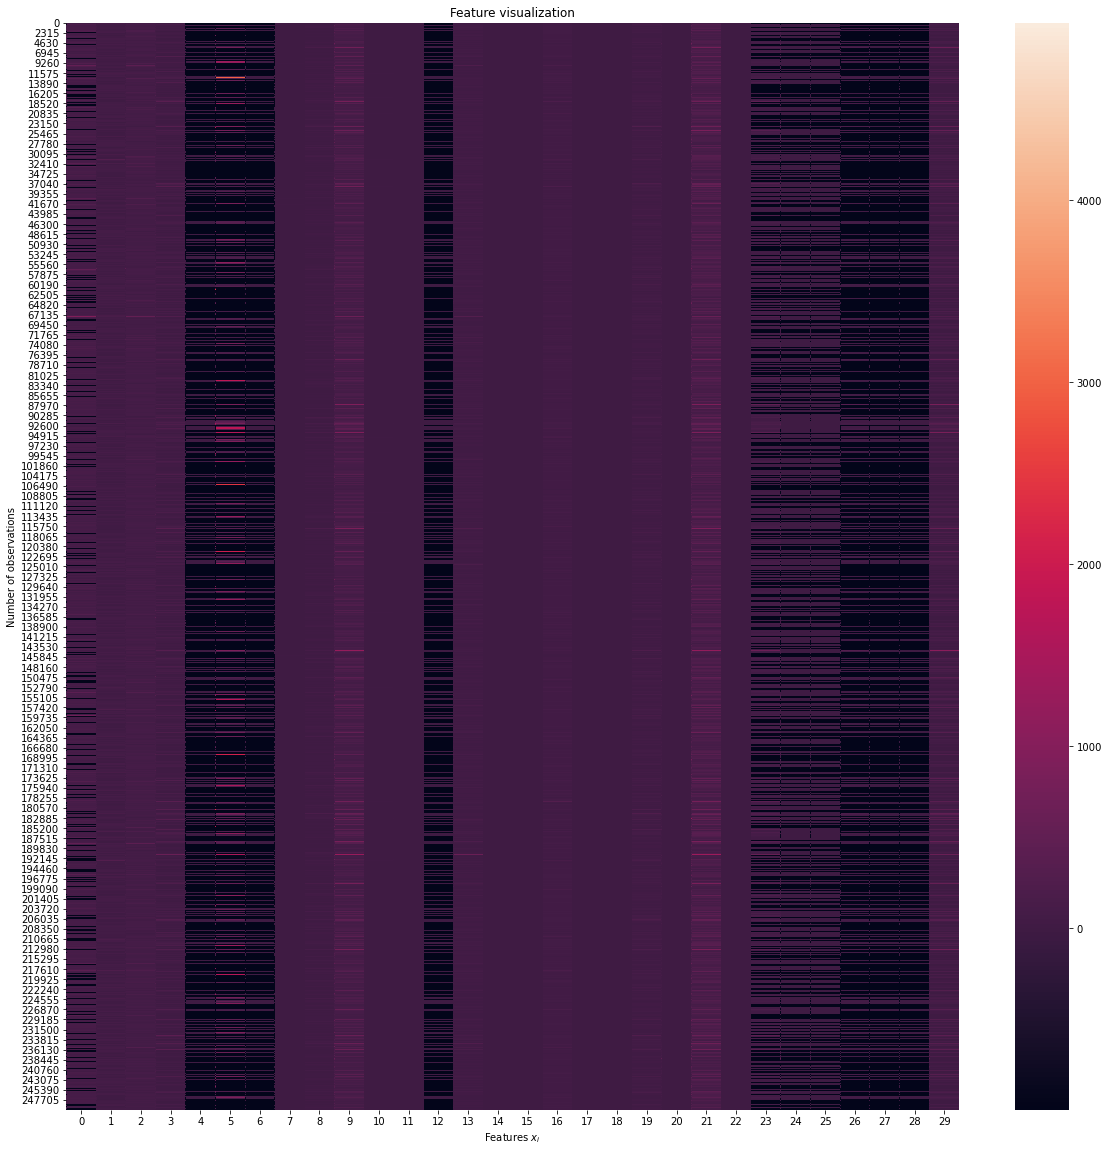

In [7]:
plt.figure(figsize=(20,20))

sns.heatmap(tx)

plt.xlabel('Features $x_{i}$')
plt.ylabel('Number of observations')
plt.title('Feature visualization')

Display data distribution for each feature

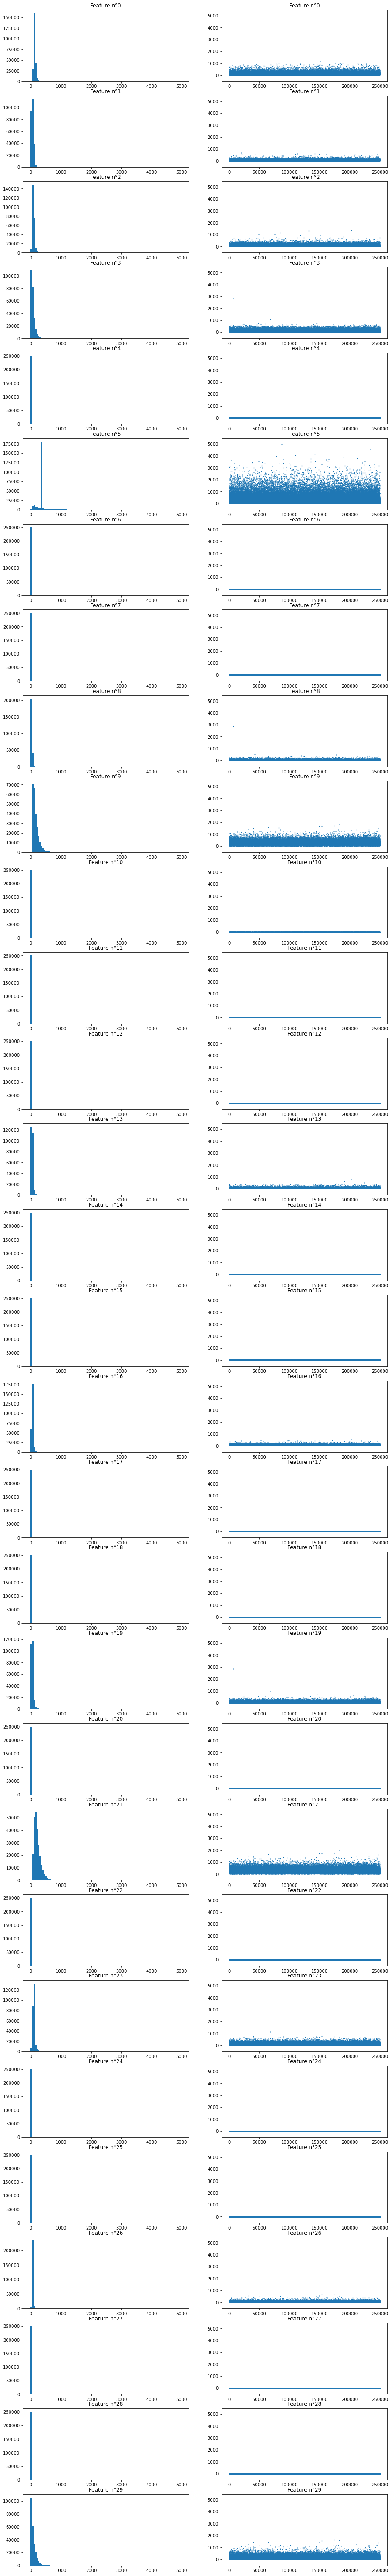

In [18]:
fig, ax = plt.subplots(30,2,figsize=(15,108))
obser = range(tx.shape[0])
for i in range(tx.shape[1]):  
    ax[i][0].hist(tx[:,i],bins=100, range=[np.min(tx),np.max(tx)])
    ax[i][0].title.set_text('Feature n°{}' .format(i))
    
    ax[i][1].scatter(obser,tx[:,i],s=1)
    ax[i][1].title.set_text('Feature n°{}' .format(i))
    ax[i][1].set_ylim(np.min(tx)-500,np.max(tx)+500)

Check similarity between features in several ways

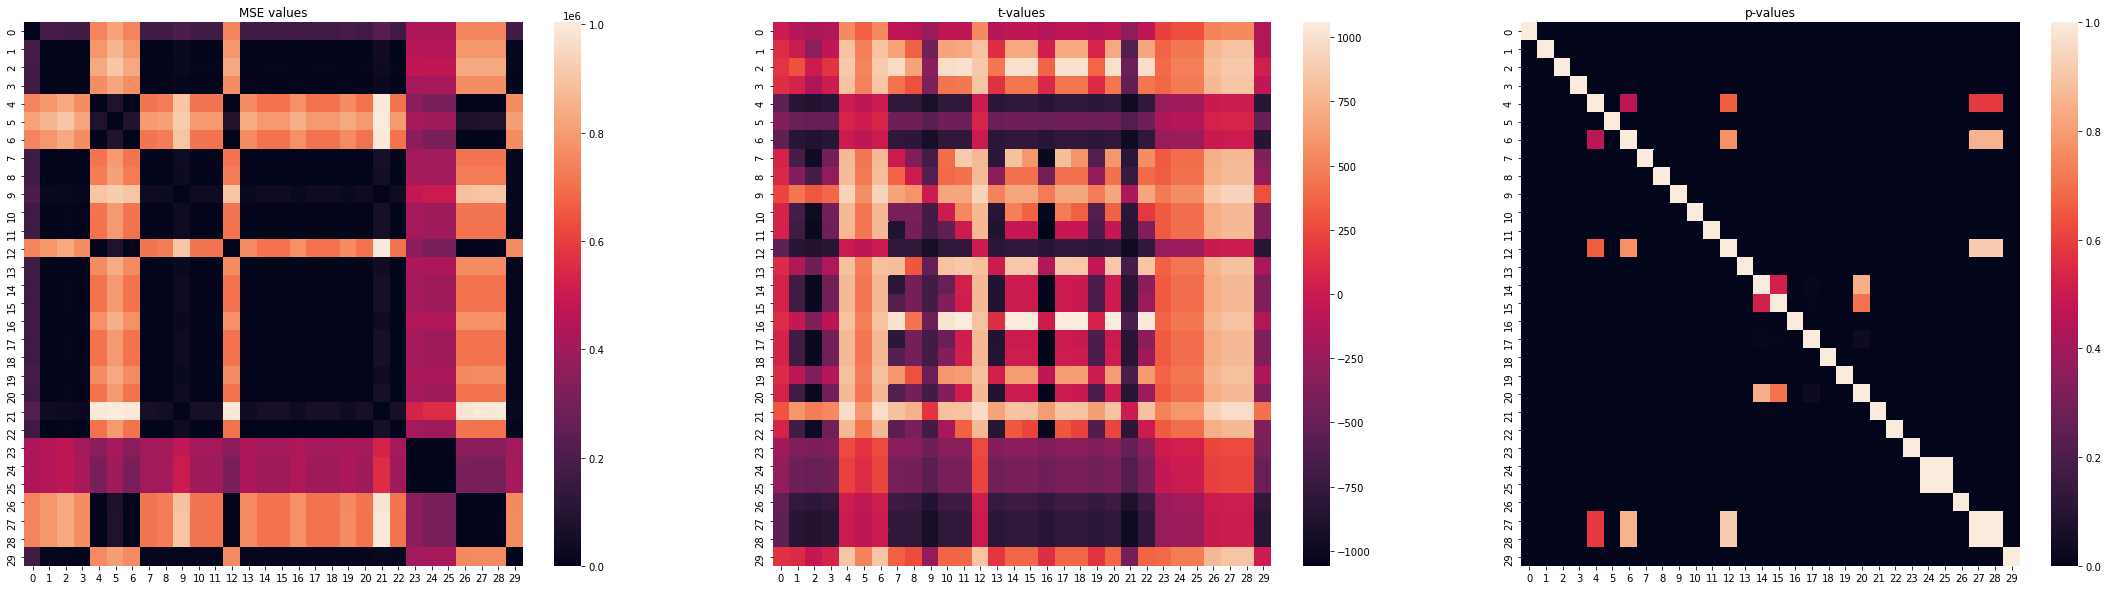

In [9]:
#MSE, t-test and p-value, correlation
import scipy
mse_all = np.zeros([tx.shape[1],tx.shape[1]])
tvalues_all = np.zeros([tx.shape[1],tx.shape[1]])
pvalues_all = np.zeros([tx.shape[1],tx.shape[1]])
for i in range(tx.shape[1]):
    ti = tx[:,i]
    for j in range(tx.shape[1]):
        tj = tx[:,j]
        mse = np.square(np.subtract(ti,tj)).mean()        
        tvalue,pvalue = scipy.stats.ttest_ind_from_stats(np.mean(ti), np.std(ti), len(ti), np.mean(tj), np.std(tj), len(tj))
        mse_all[i,j] = mse
        tvalues_all[i,j] = tvalue
        pvalues_all[i,j] = pvalue
fig, ax = plt.subplots(1,3,figsize=(38,10))
sns.heatmap(mse_all,ax=ax[0])
ax[0].title.set_text('MSE values')
sns.heatmap(tvalues_all,ax=ax[1])
ax[1].title.set_text('t-values')
sns.heatmap(pvalues_all,ax=ax[2])
ax[2].title.set_text('p-values')

## 2) Feature Processing

In [10]:
#just code to check -999 abundance in the rows/columns
M,N = tx.shape
row_list = []
col_list = []
for i in range(M):
    if np.sum((tx[i]==-999.0)) > 1:
        row_list.append(i)
for j in range(N):
    if np.sum((tx[:,j]==-999.0)) > 3:
        col_list.append(i)
print(len(row_list), len(col_list))

177457 11


In [22]:
#delete features
"""M,N = tx.shape
indices = []
for i in range(M):
    if np.sum((tx[i]==-999.0)) > 1:
        indices.append(i)
tx = np.delete(tx, indices, 0)
y = np.delete(y, indices, 0)
ids = np.delete(ids, indices, 0)"""

'M,N = tx.shape\nindices = []\nfor i in range(M):\n    if np.sum((tx[i]==-999.0)) > 1:\n        indices.append(i)\ntx = np.delete(tx, indices, 0)\ny = np.delete(y, indices, 0)\nids = np.delete(ids, indices, 0)'

In [16]:
#manipulate -999 values
def manipulate_missing_values(tx):
    tx[tx == -999.0] = np.nan
    avg_column = np.nanmean(tx, axis=0)
    indices_to_subst = np.where(np.isnan(tx))
    tx[indices_to_subst] = np.take(avg_column, indices_to_subst[1])
    return tx
tx = manipulate_missing_values(tx)

In [111]:
#normalize features
def normalize_features(tx):
    for j in range(tx.shape[1]):
        col = tx[:,j]
        tx[:,j] = (col-col.min())/(col.max()-col.min())
    return tx
tx = normalize_features(tx)

## 3) Implement ML-methods

In [20]:
#rmse calculation
def compute_error(y, tx, w):
    e = y-np.matmul(tx, w)
    return e

def compute_loss(y, tx, w):
    N = len(y)
    e = compute_error(y, tx, w)
    mse = 1/(2*N)*np.sum(e**2)
    rmse = np.sqrt(2*mse)
    return rmse

In [21]:
#gradient descent
def compute_gradient(y, tx, w):
    N = len(y)
    e = compute_error(y, tx, w)
    grad = (-1/N)*np.matmul(tx.T,e)
    return grad

def least_squares_GD(y, tx, initial_w, max_iters, gamma):
    w = initial_w
    for n_iter in range(max_iters):
        grad = compute_gradient(y, tx, w)
        w -= gamma*grad
    loss = compute_loss(y, tx, w)
    print("Gradient Descent: train loss is ", loss)
    return w, loss

In [22]:
#stochastic gradient descent
def compute_stoch_gradient(y, tx, w):
    N = len(y)
    e = compute_error(y, tx, w)
    grad = (-1/N)*np.matmul(tx.T,e)
    return grad

def least_squares_SGD(y, tx, initial_w, max_iters, gamma,  batch_size = 1):
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        for ymini, txmini in batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
            grad = compute_gradient(ymini, txmini, w)
            w -= gamma*grad
    loss = compute_loss(ymini, txmini, w)
    print("Stochastic Gradient Descent: train loss is ", loss)
    return w, loss

In [23]:
#least squares
def least_squares(y, tx):
    N = len(y)
    w = np.linalg.solve(np.matmul(tx.T, tx), np.matmul(tx.T,y))
    loss = compute_loss(y, tx, w)
    print("Least squares: train loss is ", loss)
    return w, loss

In [24]:
#ridge regression
def ridge_regression(y, phi, lambda_):
    N=len(phi)
    lambda_acc=2*N*lambda_
    kwad = np.matmul(phi.T,phi)
    w = np.linalg.solve(kwad+lambda_acc*np.eye(kwad.shape[0]),np.matmul(phi.T,y))
    loss = compute_loss(y, phi, w)
    print("Ridge regression: train loss is ", loss)
    return w, loss

In [82]:
#helper functions for logistic regression
def sigmoid(t):
    """apply the sigmoid function on t."""
    return 1/(1 + np.exp(-t))

def calculate_loss_lr(y, tx, w):
    """compute the loss: negative log likelihood."""
    pred = sigmoid(np.matmul(tx, w))
    a = np.matmul(y.T, np.log(pred)) 
    b = np.matmul((1-y).T, np.log(1-pred))
    loss = a+b
    return np.squeeze(- loss)

def calculate_gradient_lr(y, tx, w):
    """compute the gradient of loss."""
    pred = sigmoid(np.matmul(tx, w)) 
    grad = np.matmul(tx.T,(pred - y))
    return grad

def penalized_logistic_regression(y, tx, w, lambda_):
    """return the loss, gradient"""
    loss = calculate_loss_lr(y, tx, w) + lambda_*np.sum(w.T.dot(w))
    gradient = calculate_gradient_lr(y,tx,w)+2*lambda_*w
    return loss, gradient

In [87]:
#logistic regression gradient descent
def logistic_regression_gd(y, tx, initial_w, max_iters, gamma):
    w = initial_w
    for iter in range(max_iters):
        grad = calculate_gradient_lr(y, tx, w)
        w -= gamma*grad
    loss = calculate_loss_lr(y, tx, w)
    print("Logistic regression: train loss is ", loss)
    return w, loss

In [105]:
#regularized logistic regression
def logistic_regression_reg(y, tx, initial_w, max_iters, gamma, lambda_):
    w = initial_w
    for iter in range(max_iters):
        grad = penalized_logistic_regression(y, tx, w, lambda_)[1]
        w -= gamma*grad
    loss = penalized_logistic_regression(y, tx, w, lambda_)[0]
    print("Regularized logistic regression: train loss is ", loss)
    return w, loss



## 4) Analyze methods and tune hyperparameters

In [112]:
#polynomial feature augmentation
def build_poly(x, degree):
    #prof flammarion said it is possible, but i would wait a bit with doing it
    return x
"""def build_poly(x, degree):
    if degree == 0:
        return x
    else:
        N = len(x)
        phi = np.zeros((N,degree+1))
        for i in range(degree+1):
            phi[:, i] = x**i
        return phi"""

"""def build_poly_2d(x, degree):
    N,M = x.shape
    phi = np.zeros((N,30*(degree+1)))
    for i in range(M):
        col = x[:,i]
        exp = build_poly(col, degree)
        phi[:, i*(degree+1):(i+1)*(degree)] = exp
    return phi
x = np.array([[1,2,3],[4,5,6]])
print(build_poly_2d(x, 3))"""

'def build_poly_2d(x, degree):\n    N,M = x.shape\n    phi = np.zeros((N,30*(degree+1)))\n    for i in range(M):\n        col = x[:,i]\n        exp = build_poly(col, degree)\n        phi[:, i*(degree+1):(i+1)*(degree)] = exp\n    return phi\nx = np.array([[1,2,3],[4,5,6]])\nprint(build_poly_2d(x, 3))'

In [113]:
#cross validation
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)


def cross_validation(y, x, k_indices, k, degree, opt_method, initial_w, max_iters, gamma, lambda_):
    x_train_0, y_train_0 = x[k_indices[:k].ravel()], y[k_indices[:k].ravel()]
    x_train_1, y_train_1 = x[k_indices[k+1:].ravel()], y[k_indices[k+1:].ravel()]
    if x_train_0.shape[0] == 0:
        x_train = x_train_1
        y_train = y_train_1
    if x_train_1.shape[0] == 0:
        x_train = x_train_0
        y_train = y_train_0
    else:
        x_train, y_train = np.concatenate((x_train_0, x_train_1), axis=0), np.concatenate((y_train_0, y_train_1), axis=0)
    
    x_test, y_test = x[k_indices[k]], y[k_indices[k]]
    # get k'th subgroup in test, others in train

    
    phi_train = build_poly(x_train, degree)
    phi_test = build_poly(x_test, degree)
    
    if opt_method == least_squares_GD:
        w, loss_tr = opt_method(y_train, phi_train, initial_w, max_iters, gamma)
        loss_te = compute_loss(y_test, phi_test, w)
        #print('least_squares_GD')

    elif opt_method == least_squares_SGD:
        w, loss_tr = opt_method(y_train, phi_train, initial_w, max_iters, gamma,  batch_size = 1)
        loss_te = compute_loss(y_test, phi_test, w)
        #print('least_squares_SGD')

    elif opt_method == least_squares:
        w, loss_tr = opt_method(y_train, phi_train)
        loss_te = compute_loss(y_test, phi_test, w)
        #print('least_squares')

    elif opt_method == ridge_regression:
        w, loss_tr = opt_method(y_train, phi_train, lambda_)
        loss_te = compute_loss(y_test, phi_test, w)
        #print('ridge_regression')

    elif opt_method == logistic_regression_gd:
        w, loss_tr = opt_method(y_train, phi_train, initial_w, max_iters, gamma, lambda_)
        loss_te = calculate_loss_lr(y_test, phi_test, w)
        #print('logistic_regression_gd')

    elif opt_method == logistic_regression_reg:
        w, loss_tr = opt_method(y_train, phi_train, initial_w, max_iters, gamma, lambda_)
        loss_te = penalized_logistic_regression(y_test, phi_test, w, lambda_)[0]
        #print('reg_logistic_regression')

    else:
        w, loss = (None , None)
        test_loss = None
        #print("Method not found")
    
    return loss_tr, loss_te

In [114]:
def apply_cross_validation(y, x, k_indices, k_fold, degree, opt_method, initial_w = 0, max_iters = 0, gamma = 0, lambda_ = 0):
    loss_tr = []
    loss_te = []
    for k in range(k_fold):
        loss_train, loss_test = cross_validation(y, x, k_indices, k, degree, opt_method, initial_w, max_iters, gamma, lambda_)
        loss_tr.append(loss_train)
        loss_te.append(loss_test)
    rmse_tr = np.mean(np.array(loss_tr))
    rmse_te = np.mean(np.array(loss_te))
    print("Averaged train rmse after %d-fold cross-validation = %.8f"%(k_fold, rmse_tr))
    print("Averaged test rmse after %d-fold cross-validation = %.8f"%(k_fold, rmse_te))
    return rmse_tr, rmse_te

In [115]:
initial_w = np.ones((tx.shape[1]))
max_iters = 100
gamma = 0.000001
lambda_ = 0.4

In [116]:
#apply cross validation
k_fold = 4
degree = 1
k_indices = build_k_indices(y, k_fold, SEED)

rmse_tr_ls_gd, rmse_te_ls_gd = apply_cross_validation(y, tx, k_indices, k_fold, degree, least_squares_GD, initial_w, max_iters, gamma, lambda_)
#print(rmse_tr_ls_gd, rmse_te_ls_gd)

rmse_tr_ls_sgd, rmse_te_ls_sgd = apply_cross_validation(y, tx, k_indices, k_fold, degree, least_squares_SGD, initial_w, max_iters, gamma, lambda_)
#print(rmse_tr_ls_sgd, rmse_te_ls_sgd)

rmse_tr_ls, rmse_te_ls = apply_cross_validation(y, tx, k_indices, k_fold, degree, least_squares)
#print(rmse_tr_ls, rmse_te_ls)

rmse_tr_ridge, rmse_te_ridge = apply_cross_validation(y, tx, k_indices, k_fold, degree, ridge_regression, lambda_)
#print(rmse_tr_ridge, rmse_te_ridge)

rmse_tr_lr_gd, rmse_te_lr_gd = apply_cross_validation(y, tx, k_indices, k_fold, degree, logistic_regression_gd, initial_w, max_iters, gamma, lambda_)
#print(rmse_tr_lr_gd, rmse_te_lr_gd)

rmse_tr_lr_reg, rmse_te_lr_reg = apply_cross_validation(y, tx, k_indices, k_fold, degree, logistic_regression_reg, initial_w, max_iters, gamma, lambda_)
#print(rmse_tr_lr_reg, rmse_te_lr_reg)

Gradient Descent: train loss is  8.385571504847562
Gradient Descent: train loss is  8.379183548411179
Gradient Descent: train loss is  8.377846477642949
Gradient Descent: train loss is  8.376792404910452
Averaged train rmse after 4-fold cross-validation = 8.37984848
Averaged test rmse after 4-fold cross-validation = 8.37984765
Stochastic Gradient Descent: train loss is  7.98445215645024
Stochastic Gradient Descent: train loss is  9.811377549216433
Stochastic Gradient Descent: train loss is  7.690513118144187
Stochastic Gradient Descent: train loss is  7.747737579392567
Averaged train rmse after 4-fold cross-validation = 8.30852010
Averaged test rmse after 4-fold cross-validation = 8.36784207
Least squares: train loss is  0.8249118599142548
Least squares: train loss is  0.8244006887295786
Least squares: train loss is  0.8255999298887445
Least squares: train loss is  0.8249449254266016
Averaged train rmse after 4-fold cross-validation = 0.82496435
Averaged test rmse after 4-fold cross-va

## here we need to make histograms of loss functions of all methods + F1-accuracy


In [35]:

barWidth = 0.3
bars = ('LS', 'GD', 'SGD', 'RR')
y_pos = np.arange(len(bars))

# Create bars
height = rmse_list
plt.bar(y_pos, height, color=(0.2, 0.4, 0.6, 0.8))

# Create names on the x-axis
plt.xticks(y_pos, bars)
plt.title('Train loss functions (RMSE) of the different models')
plt.ylabel('RMSE')

# Show graphic
plt.show()

NameError: name 'rmse_list' is not defined

## REMARKS
* So, all methods are implemented and cross validation works :)) (i hope/think!)
* i wrote a function to normalize the features and to manipulate the -999 values by the means of the feature vector. I applied both functions on the tx data and i think its better. We could try to calculate the median instead of mean (maybe not such a difference)
* We still have to think about deleting features (cfr. correlation) and whether taking the log/ln or normalizing the features/data in a log/ln way will improve results. (hint TA)
* F1 and accuracy calculations have to be added by comparing the labels instead of the actual y vectors. This is probably more useful then the rmse (or other loss for lr) as it is a classifier. (cfr. theory class)
* A histogram displaying all losses of test and train of all methods would be nice
* MOST IMPORTANT STEP NOW: tuning hyperparameters by running loops
* QUESTION: should we do build_poly and expanding the features? (maybe yes?) and if so, probably better to expand logarithmic instead of polynomial
* After this, we are done i think and we can write the report. Probably there are other options in the data processing step (eg. PCA but i would only do this if we still have time)

In [ ]:
y_pred_ls = predict_labels(weights_ls, tx_test)
y_pred_gd = predict_labels(weights_gd, tx_test)
y_pred_sgd = predict_labels(weights_sgd, tx_test)
y_pred_rr = predict_labels(weights_rr, tx_test)


In [ ]:
indices = build_k_indices(y, 4, SEED)
rmse_tr_ls, rmse_te_ls = apply_cross_validation(y, tx, indices, 4, 8, weights_ls)

In [ ]:
first_obser = range(50)
fig, ax = plt.subplots(4,2,figsize=(25,14))

# TRAIN OBSERVATIONS
ax[0][0].scatter(first_obser,y[0:50],s=12)
ax[0][0].scatter(first_obser,y_pred_ls[0:50],s=12)
ax[0][0].title.set_text('LS train sample')
lse_correct = np.sum((y_pred_ls+y !=0)*1)*100/tx.shape[0] #percentage of correctly defined points
ax[0][0].text(2,0.3,str(lse_correct)+' % correct train predictions')
ax[0][0].text(2,0,str(loss_train[0])+' train RMSE')


ax[3][0].scatter(first_obser,y[0:50],s=12)
ax[3][0].scatter(first_obser,f_rr[0:50],s=12)
ax[3][0].title.set_text('RR train sample')
rr_correct = np.sum((y_pred_rr+y !=0)*1)*100/tx.shape[0] #percentage of correctly defined points
ax[3][0].text(2,0.3,str(rr_correct)+' % correct train predictions')
ax[3][0].text(2,0,str(loss_rr)+' train RMSE')




# TEST OBSERVATIONS
#THIS IS NOT CORRECT, BECAUSE WE DONT KNOW THE TEST LABELS

ax[0][1].scatter(first_obser,y_test[0:50],s=12)
ax[0][1].scatter(first_obser,y_pred_lse[0:50],s=12)
ax[0][1].title.set_text('LS test sample')
lse_correct = np.sum((y_pred_ls+y_test !=0)*1)*100/tx.shape[0] #percentage of correctly defined points
ax[0][1].text(2,0.3,str(lse_correct)+' % correct test predictions')
ax[0][1].text(2,0,str(loss_ls)+' test RMSE')


ax[3][1].scatter(first_obser,y_test[0:50],s=12)
ax[3][1].scatter(first_obser,y_pred_rr[0:50],s=12)
ax[3][1].title.set_text('RR test sample')
rr_correct = np.sum((y_pred_rr+y_test !=0)*1)*100/tx.shape[0] #percentage of correctly defined points
ax[3][1].text(2,0.3,str(rr_correct)+' % correct test predictions')
ax[3][1].text(2,0,str(loss_test[3])+' test RMSE')

plt.show()


## 5) Choose the best model 
## Generate predictions and save ouput in csv format for submission:

In [ ]:
OUTPUT_PATH = r'C:\Users\Tomas\GitHub\ML_course\projects\project1\predictions_sgd.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights_gd, tx_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)